# Neural Network from Scratch


## Import libraries

We will be using the lower resolution MINST data set

In [1]:
from sklearn.datasets import load_digits # The MNIST data set is in scikit learn data set
from sklearn.preprocessing import StandardScaler  # It is important in neural networks to scale the date
from sklearn.model_selection import train_test_split  # The standard - train/test to prevent overfitting and choose hyperparameters
from sklearn.metrics import accuracy_score # 
import numpy as np
import numpy.random as r # We will randomly initialize our weights
import matplotlib.pyplot as plt 

## Looking at the data

After we load the data, we print the shape of the data and a pixelated digit.

We also show what the features of one example looks like.

The neural net will learn to estimate which digit these pixels represent.

The shape of the digits dataset:
(1797, 64)


<Figure size 432x288 with 0 Axes>

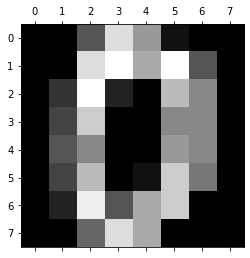

[0]
[ 0.  0.  5. 13.  9.  1.  0.  0.  0.  0. 13. 15. 10. 15.  5.  0.  0.  3.
 15.  2.  0. 11.  8.  0.  0.  4. 12.  0.  0.  8.  8.  0.  0.  5.  8.  0.
  0.  9.  8.  0.  0.  4. 11.  0.  1. 12.  7.  0.  0.  2. 14.  5. 10. 12.
  0.  0.  0.  0.  6. 13. 10.  0.  0.  0.]


In [2]:
# load all the digits (img)
digits = load_digits()

# load the data from the digit (img)
data = digits.data
target = digits.target

print("The shape of the digits dataset:") 
print(digits.data.shape)
# plot the digits
# using .gray()
# and .matshow() with argument digit.images[xx]
plt.gray()
plt.matshow(digits.images[0])
plt.show()

# get the gt for this digit img
X = data
y = target

print(y[0:1])
print(X[0,:])

## 1) Scale the dataset
The training features range from 0 to 15.  To help the algorithm converge, we will scale the data to have a mean of 0 and unit variance

In [3]:
# use the stander lib to scale the data
# init the scaler 
scaler = StandardScaler()
# fit the data to the scaler 
scaler.fit(X)
# Looking the new features after scaling
X_Scaled = scaler.transform(X)


## 2) Creating training and test datasets
We split the data into training and test data sets. We will train the neural network with the training dataset, and evaluate our neural network with the test dataset 

In [4]:
#Split the data into training and test set.  60% training and %40 test
XTrain, XTest, yTrain, yTest = train_test_split(X_Scaled, y, train_size = 0.6,test_size = 0.4, random_state=5)


## 3) Setting up the output layer

### One hot encoding

In [5]:
def convert_y_to_vect(y):
#     Our target is an integer in the range [0,..,9], so we will have 10 output neuron's in our network.  

#     If  y=0 we want the output neurons to have the values (1,0,0,0,0,0,0,0,0,0)
#     If  y=1 we want the output neurons to have the values (0,1,0,0,0,0,0,0,0,0)
#     etc

#     Thus we need to change our target so it is the same as our hoped for output of the neural network. 

#     If y=0$we change it into the vector (1,0,0,0,0,0,0,0,0,0)
#     If y=1 we change it into the vector (0,1,0,0,0,0,0,0,0,0)
#     etc

#     The code to covert the target vector.
    outputneurons = np.zeros((y.shape[0], 10))
    v=np.linspace(0,y.shape[0]-1,y.shape[0], dtype=int)
    outputneurons[v,y] = 1
    return outputneurons
    

Converting the training and test targets to vectors 

In [6]:
# convert digits to vectors using the func above

# appky this to both train and test splits
y_v_test = convert_y_to_vect(yTest)
y_v_train = convert_y_to_vect(yTrain)


A quick check to see that our code performs as we expect 

In [7]:
print(yTrain[0:4])
print(y_v_train[0:4])

[2 4 8 1]
[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


## 4) Creating the neural network

### The activation function and its derivative

In [8]:
# We will use the sigmoid activation function:  f(z)={1}/{1+e^{-z}}
def sigmoid(z):
    return 1/(1 + np.e**(-z))
    re
# The deriviative of the sigmoid function is: $f'(z) = f(z)(1-f(z))$ 
def sigmoid_deriv(z):
    return sigmoid(z)*(1-sigmoid(z))
def tanh(z):
    return (np.e**(2*z)-1)/(np.e**(2*z)+1)
def tanh_deriv(z):
    return 1-tanh(z)**2
def relu(z):
    return np.maximum(0, z)
def relu_deriv(z):
    return (z>0).astype(int)

def f(z, ftype):
    if ftype=="sigmoid":
        m=sigmoid(z)
        return m
    elif ftype=="tanh":
        m= tanh(z)
        return m
    elif ftype=="relu":
        m= relu(z)
        return m
def f_deriv(z, ftype):
    if ftype=="sigmoid_d":
        m= sigmoid_deriv(z)
        return m
    elif ftype=="tanh_d":
        m= tanh_deriv(z)
        return m
    elif ftype=="relu_d":
        m= relu_deriv(z)
        return m

    

### Creating and initialing W and b


In [9]:
def setup_and_init_weights(nn_structure):
    # The weights in W are different so that during back propagation the nodes on a level will have different gradients and thus have different update values.
    #creating a dictionary for wiehgts i.e. a set of key: value pairs
    weightsdic = {}

    #creating a dictionary for bias i.e. a set of key: value pairs
    biasdic = {}

    for i in range(1, len(nn_structure)):
        # We want the weights to be small values, since the sigmoid is almost "flat" for large inputs.
        # Next is the code that assigns each weight a number uniformly drawn from $[0.0, 1.0)$.  
        # The code assumes that the number of neurons in each level is in the python list *nn_structure*.
        # .random_sample return “continuous uniform” random floats in the half-open interval [0.0, 1.0). 
        #  numpy.random is imported in the top as r
        #divide by the squareroot in order to scale the weights so they become smaller hence would give better aacuracy
        weightsdic[i]= r.random_sample((nn_structure[i], nn_structure[i-1])) /np.sqrt(nn_structure[i])
#         print(weightsdic[i])
#         print(nn_structure[i-1])
        biasdic[i]= r.random_sample((nn_structure[i]))
        
        
    # Return weight and b
    return weightsdic, biasdic
nn_structuree=[60, 35, 10]
weight5, bias5=setup_and_init_weights(nn_structuree)
print(bias5[1].shape)

(35,)


### Initializing $\triangledown W$ and $\triangledown b$


In [10]:
def init_tri_values(nn_structure):
    # Creating dlt_W and dlt_b to have the same size as W and b,and init the dlt_W, and dlt_b to 0
    dlt_W={}
    dlt_b={}
    
    # use for loop to init the dlt W and dlt b
    for i in range (1, len(nn_structure)):
        # you can use np.zeros
        dlt_W[i] = np.zeros((nn_structure[i], nn_structure[i-1]))
        dlt_b[i] = np.zeros((nn_structure[i],))
    return dlt_W, dlt_b

## Feed forward
Perform a forward pass throught the network.  The function returns the values of $a$ and $z$

In [11]:
def feed_forward(x, W, b,ftype):
    # create a dictionary for holding the a values for all levels
    a = {1: x}
    # create a dictionary for holding the z values for all the layers
    z = {}
    for l in range(1, len(W) + 1):
            # z^(l+1) = W^(l)*a^(l) + b^(l)
        z[l+1] = W[l].dot(a[l]) + b[l]  
            # a^(l+1) = f(z^(l+1))
        a[l+1] = f(z[l+1],ftype)
        
    return a, z

## Compute $\delta$
compute $\delta^{(s_l)}$ in a function called "calculate_out_layer_delta",  and  computes $\delta^{(\ell)}$ for the hidden layers in the function called "calculate_hidden_delta".  



In [12]:
def calculate_out_layer_delta(y, a_out, z_out,functionderiv):
    # delta^(nl) = -(y_i - a_i^(nl)) * f'(z_i^(nl))
    outlayerdelta= -(y - a_out) * f_deriv(z_out,functionderiv)
    return outlayerdelta


def calculate_hidden_delta(delta_plus_1, w_l, z_l,functionderiv):
    # delta^(l) = (transpose(W^(l)) * delta^(l+1)) * f'(z^(l))
    hiddenDelta= np.dot(np.transpose(w_l), delta_plus_1) * f_deriv(z_l,functionderiv)
    return hiddenDelta

## The Back Propagation Algorithm


In [13]:
def train_nn(ftype, nn_structure, X, y, iter_num=3000, alpha=0.25):
    
    if ftype==1:
        function="sigmoid"
        functionderiv="sigmoid_d"
    elif ftype==2:
        function="tanh"
        functionderiv="tanh_d"
    elif ftype==3:
        function="relu"
        functionderiv="relu_d"    
    # init W and b
    W,b = setup_and_init_weights(nn_structure)
    # init counter to 0
    counter=0
    
    # store the length of data
    lengthofdata = X.shape[0]
    
    # init a list to store the all costs
    allcosts=[]
    
    print('Starting gradient descent for {} iterations'.format(iter_num))
    # while the counter is less than the max iterations:
    while counter <iter_num:
        # print the iteration number for every 1000 iter
        if (counter % 100 == 0):
            print("Iteration {} ".format(counter))
        
        # init delt_W and delt_b
        delta_W,delta_b = init_tri_values(nn_structure)
        # init the cost to 0
        cost = 0
        # for each data:
        for i in range(lengthofdata):
            # perform the feed forward pass and return the stored a and z values, to be used in the
            # gradient descent step
            a,z = feed_forward(X[i], W, b,function)
            deltas = {}
            # loop from nl-1 to 1 backpropagating the errors
            for la in range(len(nn_structure), 0, -1):
                #if first layer, calc out layer
                if la == len(nn_structure):
                    deltas[la] = calculate_out_layer_delta(y[i], a[la], z[la],functionderiv)
                    cost = cost + np.sqrt(np.sum((a[la] - y[i])**2))                    
                
                else:
                    #if not first layer then calculate hidden layer
                    if la>1:
                        deltas[la] = calculate_hidden_delta(deltas[la+1], W[la], z[la], functionderiv)
                        
                    # triW^(l) = triW^(l) + delta^(l+1) * transpose(a^(l))
                        # hit: you can use np.newaxis to increase the number of dimensions
                    
                    #delta^(l+1)
                    p1= deltas[la+1][:,np.newaxis]
                    #transpose(a^(l))
                    p2= np.transpose(a[la][:,np.newaxis])
                    #triW^(l) + delta^(l+1) * transpose(a^(l))
                    delta_W[la]=delta_W[la] + np.dot(p1,p2)
                    # trib^(l) = trib^(l) + delta^(l+1)
                    delta_b[la] =  delta_b[la]+ deltas[la+1]

                
        # perform the gradient descent step for the weights in each layer
        for la in range(len(nn_structure)-1,0,-1):
            W[la] = W[la] - (alpha*delta_W[la]/lengthofdata)
            b[la] = b[la] - (alpha*delta_b[la]/lengthofdata)
        
        
        # complete the average cost (mean squared error) calculation
        avgcost= cost/lengthofdata
        # append the cost to the cost list
        allcosts.append(avgcost) 
        
        # increase the counter 
        counter+=1
        
    return W, b, allcosts

In [14]:
def predict_y(W, b, X, n_layers,ftype):
    if ftype==1:
        function="sigmoid"
    elif ftype==2:
        function="tanh"
    elif ftype==3:
        function="relu"
    # store the length of data
    lengthofdata = X.shape[0]  
    # init for prediction array
    predictionArray = []
    # for each data:
    for i, n in enumerate(X):
        # feed forward
        a,z=feed_forward(n, W, b, function)
        # predict
#         print(a[n_layers])
#         print(max(a[n_layers]))
        m=max(a[n_layers])
        maxIndexes=[l for l, j in enumerate(a[n_layers]) if j == m]
        firstmaxIndex=maxIndexes[:1]
#         print(firstmaxIndex[0])
        predictionArray.append(firstmaxIndex[0])
    return predictionArray

## Running the neural network (Sigmoid)
### Iter Num= 3000
### structure= [64, 30, 10]
Our code assumes the size of each layer in our network is held in a list.  The input layer will have 64 neurons (one for each pixel in our 8 by 8 pixelated digit).  Our hidden layer has 30 neurons (you can change this value).  The output layer has 10 neurons.

Next we create the python list to hold the number of neurons for each level and then run the neural network code with our training data.

This code will take some time...

In [15]:
nn_structure = [64,30, 10]
iter_num = 3000
# train the NN with the nn_structure and 3000 iterations
W1, b1, costList1 = train_nn(1,nn_structure, XTrain, y_v_train, iter_num)


Starting gradient descent for 3000 iterations
Iteration 0 
Iteration 100 
Iteration 200 
Iteration 300 
Iteration 400 
Iteration 500 
Iteration 600 
Iteration 700 
Iteration 800 
Iteration 900 
Iteration 1000 
Iteration 1100 
Iteration 1200 
Iteration 1300 
Iteration 1400 
Iteration 1500 
Iteration 1600 
Iteration 1700 
Iteration 1800 
Iteration 1900 
Iteration 2000 
Iteration 2100 
Iteration 2200 
Iteration 2300 
Iteration 2400 
Iteration 2500 
Iteration 2600 
Iteration 2700 
Iteration 2800 
Iteration 2900 


### Plotting the learning curve


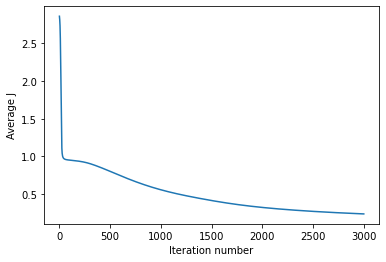

In [16]:
# plot the avg_cost_func 
plt.plot(costList1)
# x label: "Iteration number"
plt.xlabel('Iteration number')
# y label: "Average J"
plt.ylabel('Average J')
plt.show()

## 5) Assessing accuracy
Next we determine what percentage the neural network correctly predicted the handwritten digit correctly on the test set

In [17]:
# get the prediction accuracy and print
y_pred1=predict_y(W1,b1,XTest,len(nn_structure),1)
# print(W1)
# print(b1)
print('Prediction accuracy is {}%'.format(accuracy_score(yTest, y_pred1) * 100))

Prediction accuracy is 95.41029207232266%


## Running the neural network (TanH)
### Iter Num= 3000
### structure= [64, 30, 10]

Starting gradient descent for 3000 iterations
Iteration 0 
Iteration 100 
Iteration 200 
Iteration 300 
Iteration 400 
Iteration 500 
Iteration 600 
Iteration 700 
Iteration 800 
Iteration 900 
Iteration 1000 
Iteration 1100 
Iteration 1200 
Iteration 1300 
Iteration 1400 
Iteration 1500 
Iteration 1600 
Iteration 1700 
Iteration 1800 
Iteration 1900 
Iteration 2000 
Iteration 2100 
Iteration 2200 
Iteration 2300 
Iteration 2400 
Iteration 2500 
Iteration 2600 
Iteration 2700 
Iteration 2800 
Iteration 2900 


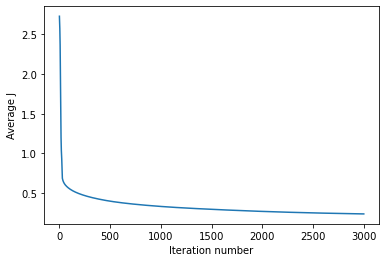

In [18]:
# train the NN with the nn_structure and 3000 iterations
W2, b2, costList2 = train_nn(2,nn_structure, XTrain, y_v_train, iter_num)
# plot the avg_cost_func 
plt.plot(costList2)
# x label: "Iteration number"
plt.xlabel('Iteration number')
# y label: "Average J"
plt.ylabel('Average J')
plt.show()


In [19]:
# print(W2)
# print(b2)
y_pred2=predict_y(W2,b2,XTest,len(nn_structure),2)
print('Prediction accuracy is {}%'.format(accuracy_score(yTest, y_pred2) * 100))


Prediction accuracy is 96.105702364395%


## Running the neural network (Relu)
### Iter Num= 3000
### structure= [64, 30, 10]

Starting gradient descent for 3000 iterations
Iteration 0 
Iteration 100 
Iteration 200 
Iteration 300 
Iteration 400 
Iteration 500 
Iteration 600 
Iteration 700 
Iteration 800 
Iteration 900 
Iteration 1000 
Iteration 1100 
Iteration 1200 
Iteration 1300 
Iteration 1400 
Iteration 1500 
Iteration 1600 
Iteration 1700 
Iteration 1800 
Iteration 1900 
Iteration 2000 
Iteration 2100 
Iteration 2200 
Iteration 2300 
Iteration 2400 
Iteration 2500 
Iteration 2600 
Iteration 2700 
Iteration 2800 
Iteration 2900 


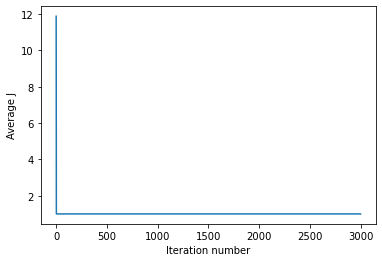

Prediction accuracy is 10.15299026425591%


In [20]:
# train the NN with the nn_structure and 3000 iterations
W3, b3, costList3 = train_nn(3,nn_structure, XTrain, y_v_train, iter_num)
# plot the avg_cost_func 
plt.plot(costList3)
# x label: "Iteration number"
plt.xlabel('Iteration number')
# y label: "Average J"
plt.ylabel('Average J')
plt.show()
y_pred3=predict_y(W3,b3,XTest,len(nn_structure),3)
print('Prediction accuracy is {}%'.format(accuracy_score(yTest, y_pred3) * 100))


## Expereiemnting with own parapeters on TanH function
### Iter Num= 2000
### structure= [64, 30, 20, 10]

Starting gradient descent for 2000 iterations
Iteration 0 
Iteration 100 
Iteration 200 
Iteration 300 
Iteration 400 
Iteration 500 
Iteration 600 
Iteration 700 
Iteration 800 
Iteration 900 
Iteration 1000 
Iteration 1100 
Iteration 1200 
Iteration 1300 
Iteration 1400 
Iteration 1500 
Iteration 1600 
Iteration 1700 
Iteration 1800 
Iteration 1900 


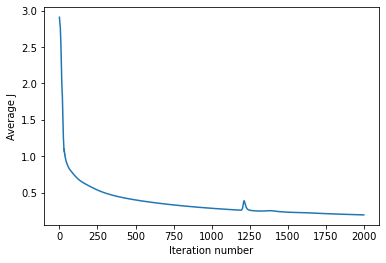

Prediction accuracy is 96.52294853963839%


In [23]:
# train the NN with the nn_structure and 3000 iterations
iter_num4=2000
nn_structure4=[64, 30, 20, 10]

W4, b4, costList4 = train_nn(2,nn_structure4, XTrain, y_v_train, iter_num4)
# plot the avg_cost_func 
plt.plot(costList4)
# x label: "Iteration number"
plt.xlabel('Iteration number')
# y label: "Average J"
plt.ylabel('Average J')
plt.show()
y_pred4=predict_y(W4,b4,XTest,len(nn_structure4),2)
print('Prediction accuracy is {}%'.format(accuracy_score(yTest, y_pred4) * 100))

# Reporting

* Sigmoid function with 3000 iteration and nn_structure= [64, 30, 10] gave accuracy of 95.41029207232266%%

* TanH function with 3000 iteration and nn_structure= [64, 30, 10] gave accuracy of 96.105702364395%

* Relu function with 3000 iteration and nn_structure= [64, 30, 10] gave accuracy of 10.15299026425591%

* Tanh function with 2000 iteration and nn_structure= [64,30,20, 10] gave accuracy of 96.52294853963839%

Based on my results the best functions to use was the TanH function gave the best accuracies, it was slightly better than Sigmoid by 1 %, but both equlively yeilded high precenteges. The worst function to  use is the Relu as it yeilded 10% accuracy rate, which is waay lower than any of the other functions. I also tried my own parameters, using Tanh function of 4 layers and 2000 iteration and it also yeilded into a high accuracy rate.


In [22]:
# print(y_pred1)
# print(yTest)
# print(y_v_test)